In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torch.serialization

# ---- Load Keras Skin Lesion Model ----
best_model = tf.keras.models.load_model('skin_classification.h5', compile=False)
IMG_SIZE = best_model.input_shape[1:3]
class_labels = ['benign', 'malignant', 'insect_bite', 'no_bites']

# ---- Load PyTorch Insect Bite Model ----
try:
    with torch.serialization.safe_globals([transforms.Compose]):
        checkpoint = torch.load(
            'insect_modelformal.pt',
            map_location='cuda' if torch.cuda.is_available() else 'cpu',
            weights_only=False
        )
except Exception as e:
    raise ValueError(f"Model loading failed: {str(e)}") from None

required_keys = {'state_dict', 'classes', 'transform'}
if not all(key in checkpoint for key in required_keys):
    missing = required_keys - set(checkpoint.keys())
    raise KeyError(f"Checkpoint missing required keys: {missing}")

# ---- Define CNN Architecture ----
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64 * 32 * 32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
insect_model = CNN(num_classes=len(checkpoint['classes'])).to(device)
insect_model.load_state_dict(checkpoint['state_dict'])
insect_model.eval()

# ---- Combined Prediction Function ----
def predict_combined(image_path):
    # ---- Step 1: Predict with Keras model ----
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    pred = best_model.predict(img_array, verbose=0)
    class_idx = np.argmax(pred[0])
    confidence = np.max(pred[0])
    predicted_class = class_labels[class_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Keras Prediction: {predicted_class} ({confidence*100:.1f}%)")
    plt.show()

    # ---- Step 2: If not 'insect_bite', return directly ----
    if predicted_class != "insect_bite":
        print(f"\n✅ Final Prediction: {predicted_class} ({confidence*100:.1f}% confidence)")
        return predicted_class

    # ---- Step 3: If 'insect_bite', refine with PyTorch model ----
    try:
        img_pil = Image.open(image_path).convert('RGB')
        img_tensor = checkpoint['transform'](img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = insect_model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            confidence_insect, pred_insect = torch.max(probs, 0)
            insect_class = checkpoint['classes'][pred_insect.item()]

        print(f"\n🐞 Refined Insect Prediction: {insect_class} ({confidence_insect.item()*100:.1f}%)")
        print("\nClass Probabilities:")
        for i, prob in enumerate(probs):
            print(f"- {checkpoint['classes'][i]}: {prob.item()*100:.1f}%")

        return insect_class

    except Exception as e:
        print(f"\n❌ Error during insect model prediction: {str(e)}")
        return None



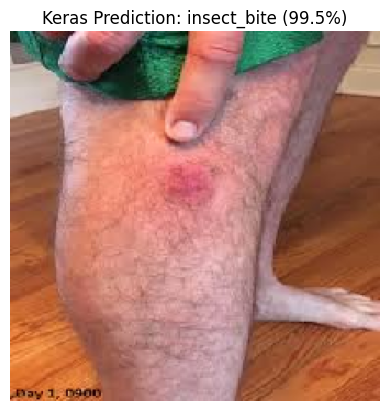


🐞 Refined Insect Prediction: ts (100.0%)

Class Probabilities:
- abcf: 0.0%
- ts: 100.0%


'ts'

In [7]:
# ---- Usage Example ----
image_path = r"C:\Users\rithi\Downloads\Soft computing Project Resouces\insect bite untouched\training\spiders\brown_recluse_spiderimage1.jpg"
predict_combined(image_path)


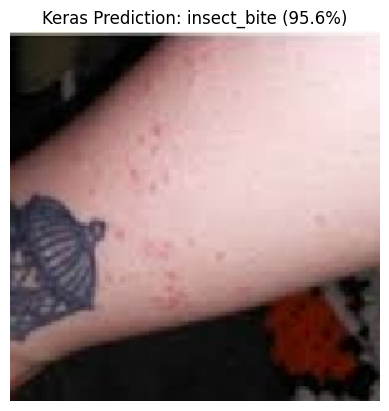


🐞 Refined Insect Prediction: abcf (100.0%)

Class Probabilities:
- abcf: 100.0%
- ts: 0.0%


'abcf'

In [8]:
image_path = r"C:\Users\rithi\Downloads\Soft computing Project Resouces\ins_train\insect_bite\chiggersimage298.jpg"
predict_combined(image_path)

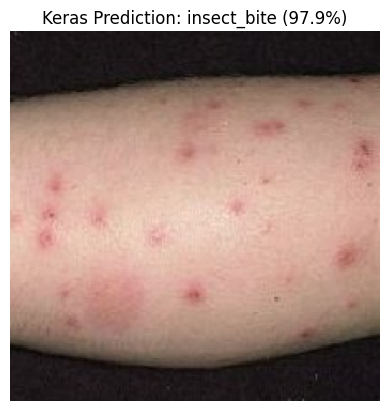


🐞 Refined Insect Prediction: abcf (99.7%)

Class Probabilities:
- abcf: 99.7%
- ts: 0.3%


'abcf'

In [11]:
image_path=r"C:\Users\rithi\Downloads\Soft computing Project Resouces\insect bite untouched\testing\fleas\picadura de pulga_15 (2).jpg"
predict_combined(image_path)

In [14]:
#abcf- {ants , bugs , chiggers , fleas}


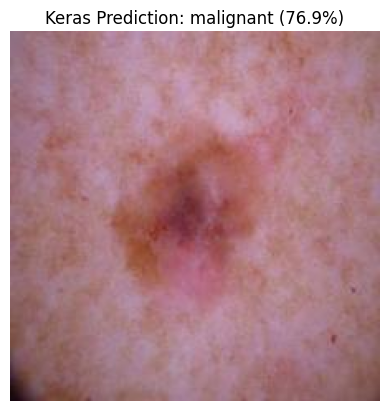


✅ Final Prediction: malignant (76.9% confidence)


'malignant'

In [12]:
image_path=r"C:\Users\rithi\Downloads\Soft computing Project Resouces\skin_test\Malignant\6553.jpg"
predict_combined(image_path)

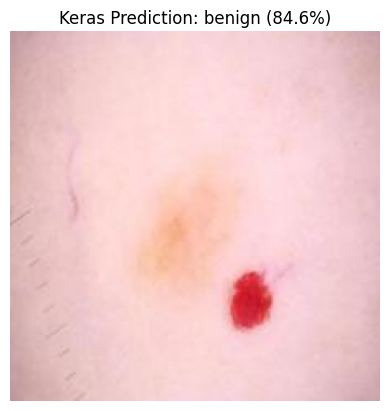


✅ Final Prediction: benign (84.6% confidence)


'benign'

In [13]:
image_path=r"C:\Users\rithi\Downloads\Soft computing Project Resouces\skin_test\Benign\7274.jpg"
predict_combined(image_path)